<a href="https://colab.research.google.com/github/LanesG/colab/blob/master/CNN_Dog_Races.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importieren der Libraries

In [1]:
!pip install --upgrade deeplearning2020

     |████████████████████████████████| 399kB 6.5MB/s 
  Created wheel for deeplearning2020: filename=deeplearning2020-0.4.21-py2.py3-none-any.whl size=8548 sha256=214b58bcff5e6ba7fe7639cb20fa3392a42de6954d1f8cb8e149870c53cdf00a
  Stored in directory: /root/.cache/pip/wheels/7f/c2/8a/f9f03fc839999f1fe9d5e5a9d2c97cdd5cb8329f61f82ea2c9
  Created wheel for kerasltisubmission: filename=kerasltisubmission-0.4.9-py2.py3-none-any.whl size=8867 sha256=a3a62c95501d90c1c6822d570e3841d387fefba1d870c22ae361e5b18211a7a4
  Stored in directory: /root/.cache/pip/wheels/fd/61/f7/09171376b25408ae21b58e98c9fbf2eb924f676bb77659f983
Successfully built deeplearning2020 kerasltisubmission


In [0]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, BatchNormalization, GaussianNoise, \
  Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

from deeplearning2020 import helpers

In [0]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.\nGo to Runtime > Change runtime and select a GPU hardware accelerator.")

# Die Daten

## Laden der Daten

In [4]:
from deeplearning2020.datasets import ImageWoof

train_data, test_data, classes = ImageWoof.load_data()

328294400/328288506 [==============================] - 7s 0us/step
/root/.keras/datasets/imagewoof2-320/train
Loaded 9025 images
/root/.keras/datasets/imagewoof2-320/val
Loaded 3929 images


## Informationen über die Datensätze anzeigen
Die Bildpunkte sind als Floats zwischen 0 und 1 gespeichert.  
Die Labels der Daten liegen in sparse Form vor.

In [5]:
print("Trainingsdaten")
print(train_data)

print("Testdaten")
print(test_data)

print("Klassen")
print(classes)

Trainingsdaten
<ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
Testdaten
<ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
Klassen
['Shih-Tzu' 'Rhodesian ridgeback' 'Beagle' 'English foxhound'
 'Border terrier' 'Australian terrier' 'Golden retriever'
 'Old English sheepdog' 'Samoyed' 'Dingo']


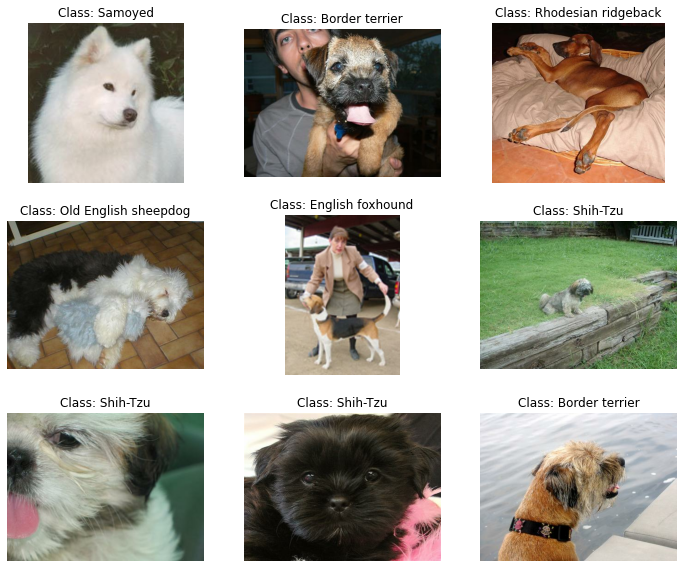

In [6]:
helpers.plot_images(train_data.take(9), classes)

## Preprocessing der Daten
Um mit den Bilddaten arbeiten zu können, müssen diese eine einheitliche Größe haben. Dafür steht die Funktion `preprocess` bereit, die alle Bilder in die vorgegebene Größe umwandelt.

In [0]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [300, 300])
    return resized_image, label

Anwendung der `preprocess` Funktion auf alle Daten.  
`.batch` bereitet den nächsten Batch mit festeglegter Größe vor.  
`.prefetch` lädt den nächsten Batch schon in den Speicher.

In [8]:
# Festlegung der Batch Größe für die Datenvorbereitung
batch_size = 32 

# Durchmischen der Trainingsdaten, dass nicht mit sortierten Bildern trainiert wird 
train_data = train_data.shuffle(1000) 

print('shape des Trainigsdatensatzes vor dem preprocessing: ', train_data)

train_data = train_data.map(preprocess) \
  .batch(batch_size).prefetch(1)          
test_data = test_data.map(preprocess) \
  .batch(batch_size).prefetch(1)

print('shape des Traingingsdatensatzes nach dem preprocessing: ', train_data)

shape des Trainigsdatensatzes vor dem preprocessing:  <ShuffleDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
shape des Traingingsdatensatzes nach dem preprocessing:  <PrefetchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>


# Das Netz

## Hyperparameter

In [0]:
dense_neurons=1000
n_filters=64
activation='elu'
learning_rate=0.001
momentum=0.9
decay=0.002
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay)

## Die Layer

In [0]:
# Inputgröße muss 300x300 Pixel mit 3 RGB Farben betragen
input_layer = Input(shape=(300, 300, 3))
input = BatchNormalization(axis=[1, 2])(input_layer)

input = GaussianNoise(0.1)(input_layer)

model = Conv2D(
  filters=n_filters,
  kernel_size=(7,7),
  activation=activation,
)(input)
model = BatchNormalization(axis=[1, 2])(model)
model = MaxPooling2D((2, 2))(model)

for i in range(2, 5):
  model = Conv2D(
    filters = i * n_filters, 
    kernel_size=(3, 3), 
    activation=activation
  )(model)
  model = Conv2D(
    filters = i * n_filters, 
    kernel_size=(3, 3), 
    activation=activation,
      padding='same'
  )(model)
  model = BatchNormalization(axis=[1, 2])(model)
  model = MaxPooling2D((2, 2))(model)

model = Conv2D(
  filters = 5 * n_filters,
  kernel_size=(3, 3),
  activation=activation,
  padding='same'
)(model)
model = Conv2D(
  filters = 5 * n_filters,
  kernel_size=(3, 3),
  activation=activation,
  padding='same'
)(model)
model = BatchNormalization(axis=[1, 2])(model)
model = MaxPooling2D((2, 2))(model)

model = Flatten()(model)

model = Dense(
  dense_neurons,
  activation=activation
)(model)
model = BatchNormalization()(model)
model = Dropout(0.5)(model)

model = Dense(
  dense_neurons / 2,
  activation=activation
)(model)
model = BatchNormalization()(model)
model = Dropout(0.5)(model)

# Output Layer
output = Dense(10, activation='softmax')(model)

CNN_model = Model(input_layer, output)

In [11]:
CNN_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 294, 294, 64)      9472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 294, 294, 64)      345744    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 147, 147, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 145, 145, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 145, 145, 128)     147584

## Kompilieren des Netzes

In [0]:
CNN_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

## Trainieren des Netzes

In [13]:
history = CNN_model.fit(
    train_data,
    epochs=40,
    validation_data=test_data
)

Epoch 1/40
283/283 [==============================] - 103s 363ms/step - loss: 2.9975 - accuracy: 0.1578 - val_loss: 2.1442 - val_accuracy: 0.2135
Epoch 2/40
283/283 [==============================] - 101s 358ms/step - loss: 2.6024 - accuracy: 0.1803 - val_loss: 2.1076 - val_accuracy: 0.2204
Epoch 3/40
283/283 [==============================] - 101s 358ms/step - loss: 2.4271 - accuracy: 0.2010 - val_loss: 2.2084 - val_accuracy: 0.1830
Epoch 4/40
283/283 [==============================] - 101s 358ms/step - loss: 2.3188 - accuracy: 0.2201 - val_loss: 2.0181 - val_accuracy: 0.2741
Epoch 5/40
283/283 [==============================] - 101s 358ms/step - loss: 2.2164 - accuracy: 0.2363 - val_loss: 1.9988 - val_accuracy: 0.2721
Epoch 6/40
283/283 [==============================] - 101s 358ms/step - loss: 2.1711 - accuracy: 0.2474 - val_loss: 1.9018 - val_accuracy: 0.3199
Epoch 7/40
283/283 [==============================] - 101s 358ms/step - loss: 2.0906 - accuracy: 0.2694 - val_loss: 1.9202 -

## Evaluieren des Netzes

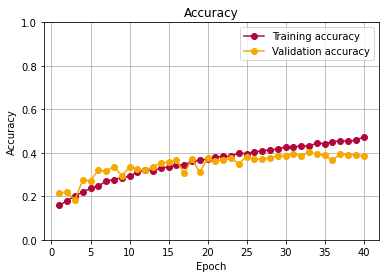

In [14]:
helpers.plot_history('Accuracy', history, 0)

In [15]:
eval_loss, eval_accuracy = CNN_model.evaluate(test_data)
print("Model accuracy: %.2f" % eval_accuracy)
print(eval_loss)

123/123 [==============================] - 10s 84ms/step - loss: 1.7791 - accuracy: 0.3833
Model accuracy: 0.38
1.7791391611099243
